In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [2]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [3]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min=-100, x_max=100, nbins=NBINS, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        #plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [4]:
# First trying sampling from a simple gaussian distribution
@inverse_sample_decorator
def gauss(x, amp=1.0, mean=0.0, std=0.2):
    return amp*np.exp(-(x-mean)**2/std**2/2.0)

In [5]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [6]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False, signal=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        if signal:
            print(samples.shape)
            sig_samples, _ = gauss(na//100, mean=3.5, std=0.5)
            print(sig_samples.shape)
            samples = np.concatenate((samples, sig_samples))
            print(samples.shape)
        
        plt.style.use("dark_background")
        
        
        n, bins = np.histogram(samples, bins=nbins)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [7]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("./data/bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("./data/bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,NBINS+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [8]:
def prob2event(x):
    x = np.array(x)
    x.reshape(NBINS)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(NBINS)
    return x

In [9]:
def plot1(X, Y, binsc=binsc, legend=True):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y), s=6, label="bin prob", c="orange")
    if legend:
        plt.legend()
    plt.show()

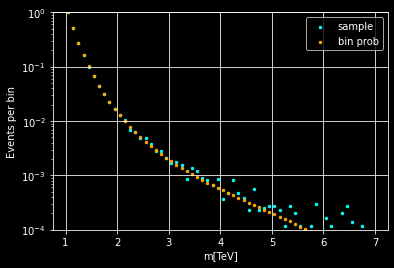

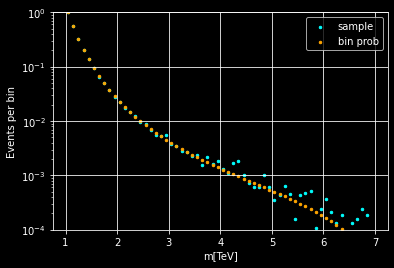

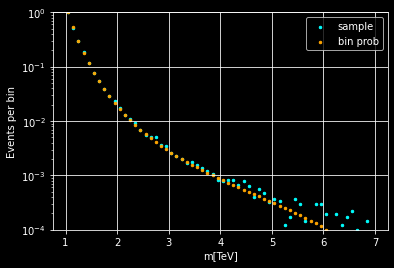

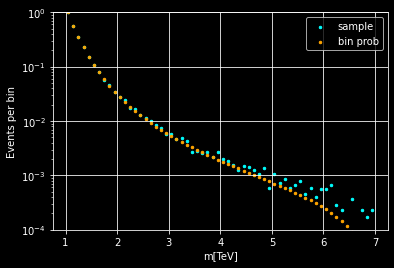

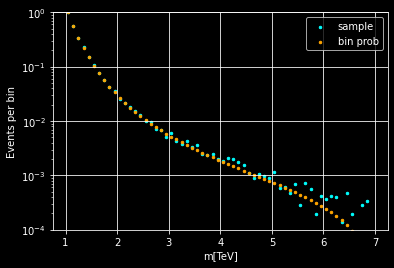

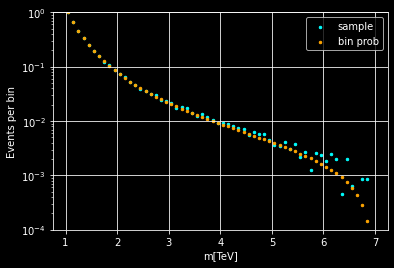

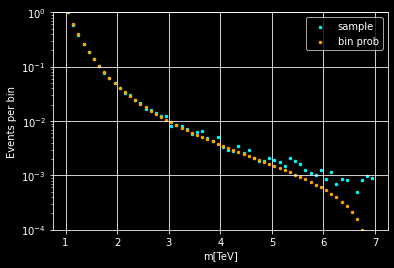

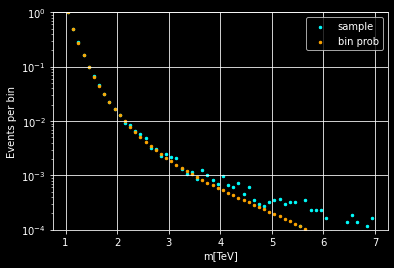

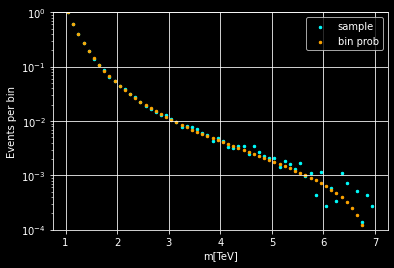

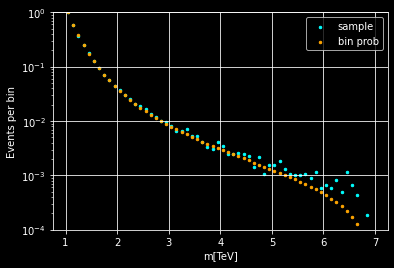

In [10]:
for i in np.random.randint(NP, size=10):
    plot1(X[i,:], Y[i,:])

In [11]:
import tensorflow.keras as keras
import tensorflow as tf

GPUMS = 4
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPUMS*1024)])
    except RuntimeError as e:
        print(e)

In [12]:
def create_s2s(latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, 1), name='encoder_inputs')
    encoder = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, 1), name='decoder_inputs')

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    
    print(encoder_outputs.shape, decoder_outputs.shape)
    #Attention
    attn_outputs = keras.layers.Attention()([encoder_outputs, decoder_outputs])
    # Concat attention input and decoder LSTM output
    decoder_concat_inputs = keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_outputs])
    
    #Dense layer
    decoder_dense = keras.layers.Dense(1, activation="linear")
    decoder_outputs = decoder_dense(decoder_concat_inputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [13]:
def train_model(sample_weight, modeln, X, Y, TRAIN=True, PLOSS=True, verbose=1):
    
    print("    Training {}...".format(modeln))
    
    info = [int(i) for i in modeln.split("_")[1:-2]]
    latent_dim, batch_size, patience, epochs = info
    print("    latent_dim={}".format(latent_dim))
    print("    batch_size={}".format(batch_size))
    print("    patience={}".format(patience))
    print("    epochs={}".format(epochs))
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                               patience=patience, verbose=0,
                                               mode='auto', baseline=None,
                                               restore_best_weights=True)]


    Y_shifted = np.roll(Y,1)
    if TRAIN:
        model = create_s2s(latent_dim)
        if verbose:
            print(model.summary())
        model.compile(optimizer="adam", loss="mse")
        history = model.fit(
            [X, Y_shifted],
            Y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            verbose=verbose,
            callbacks=callbacks,
            sample_weight=sample_weight)
        if PLOSS:
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Loss')
            plt.yscale("log")
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['train', 'val'], loc='upper right')
            plt.show()

    model.save(modeln)

In [82]:
def create_decode(modeln, TRAIN=True, verbose=0):
    # Define sampling models
    # Restore the model and construct the encoder and decoder.
    if TRAIN:
        model = keras.models.load_model(modeln)
    else:  
        model = keras.models.load_model("./models/s2s_stable")

    latent_dim = int(modeln.split("_")[1])
    print(latent_dim)
    encoder_inputs = model.input[0]  # input_1
    #encoder_lstm = model.layers[2]
    encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
    
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = keras.Model(encoder_inputs, [encoder_outputs] + encoder_states)

    if verbose:
        print(encoder_model.summary())
        keras.utils.plot_model(encoder_model, to_file='./png/encoder.png')
        
    decoder_inputs = model.input[1]  # input_2
    decoder_state_input_h = keras.Input(shape=(latent_dim,))
    decoder_state_input_c = keras.Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[3]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h_dec, state_c_dec]
    
    attention = model.layers[4]
    attn_outputs = attention([encoder_outputs, decoder_outputs])
    decoder_concat = model.layers[5]
    decoder_concat_inputs = decoder_concat([decoder_outputs, attn_outputs])

    decoder_dense = model.layers[6]
    decoder_outputs = decoder_dense(decoder_concat_inputs)
    decoder_model = keras.Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )
    
    if verbose:
        print(decoder_model.summary())
        keras.utils.plot_model(decoder_model, to_file='./png/decoder.png')
    return encoder_model, decoder_model

In [83]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 0.5

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_dist = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_char = output_tokens[0,0,0]
        #print(sampled_char)
        decoded_dist.append(sampled_char)

        # Exit condition: either hit max length
        if len(decoded_dist) == 60:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = sampled_char

        # Update states
        states_value = [h, c]
    return decoded_dist

In [84]:
def test1(lowp, highp, modeln, ne=NE, plot=True, signal=False, s2s=True, verbose=0):
    print("    Testing {}...".format(modeln))
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True,signal=signal)
    X_test = X_test.reshape(1, X_test.shape[0], 1)
    Y_test = Y_test.reshape(1, Y_test.shape[0], 1)

    if s2s:
        encoder_model, decoder_model = create_decode(modeln, verbose=verbose)
        Y_hat = decode_sequence(X_test, encoder_model, decoder_model)
    else:
        model = keras.models.load_model(modeln)
        Y_hat = model.predict(X_test) 
    mse = np.sum((Y_hat - Y_test)**2)
    print("    Test MSE: {}".format(mse))
    print("    Test Sum: {}".format(sum(Y_hat)))
    

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="predict bin prob ({:.2f})".format(mse), c="red")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("Test on parametric ({},{})".format(lowp, highp))
        if signal:
            plt.title("Test on parametric ({},{}) with injected signal".format(lowp, highp))
            plt.axvline(x=3.5, alpha=0.6, linestyle="--", c='r')
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

In [85]:
def train_save(sample_weight, X, Y, latent_dim=256, batch_size=64, patience=25, epochs=100, verbose=1):
    
    modeln = "./models/s2sAttn_{}_{}_{}_{}_{:.1f}_exp".format(latent_dim, batch_size, patience, epochs, 
                                                float(sum(sample_weight[0].reshape(NBINS))))
    
    print("Curr model: {}".format(modeln))
    
    train_model(sample_weight, modeln, X, Y, TRAIN=True, verbose=verbose)
    
    return modeln

(60,) (60,)
(10000, 60, 1)


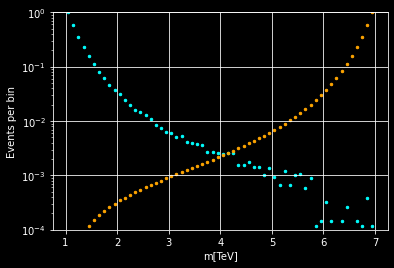

In [20]:
X_test,Y_test,binsc= data_gen(1.2,1.8,NE,1,f,scaled=True,signal=False)
print(X_test.shape, Y_test.shape)

sample_weight = Y_test[::-1]
sample_weight = np.tile(sample_weight, Y.shape[0]).reshape(Y.shape)
#sample_weight = np.repeat(sample_weight, repeats=Y.shape[0])
print(sample_weight.shape)
plot1(X_test, sample_weight[0].flatten(), legend=False)

Curr model: ./models/s2sAttn_16_32_1_3_1.0_exp
    Training ./models/s2sAttn_16_32_1_3_1.0_exp...
    latent_dim=16
    batch_size=32
    patience=1
    epochs=3
(None, None, 16) (None, None, 16)


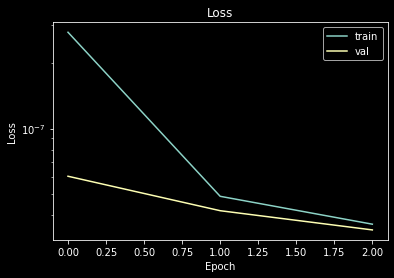

INFO:tensorflow:Assets written to: ./models/s2sAttn_16_32_1_3_1.0_exp/assets


In [41]:
modeln = train_save(sample_weight, X, Y, latent_dim=16, batch_size=32, patience=1, epochs=3, verbose=0)

In [86]:
test1(1.2, 1.8, modeln, verbose=1)

    Testing ./models/s2sAttn_16_32_1_3_1.0_exp...
16
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, None, 1)]         0         
_________________________________________________________________
encoder (LSTM)               [(None, None, 16), (None, 1152      
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("encoder_inputs_17:0", shape=(None, None, 1), dtype=float32) at layer "encoder". The following previous layers were accessed without issue: ['decoder']

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, None, 16), ( 1152        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder (LSTM)                  [(None, None, 16), ( 1152        decoder_inputs[0][0]             
                                                                 encoder[0][1]        

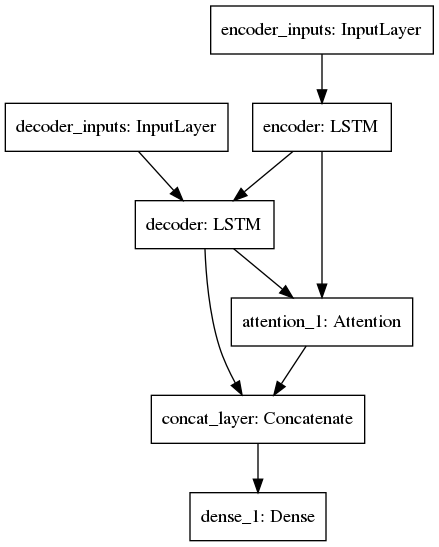

In [88]:
modelx = keras.models.load_model(modeln)
modelx.summary()

keras.utils.plot_model(modelx, to_file='./png/model.png')

Curr model: ./models/s2s_16_128_50_500_1.000000_exp
    Training ./models/s2s_16_128_50_500_1.000000_exp...
    latent_dim=16
    batch_size=128
    patience=50
    epochs=500


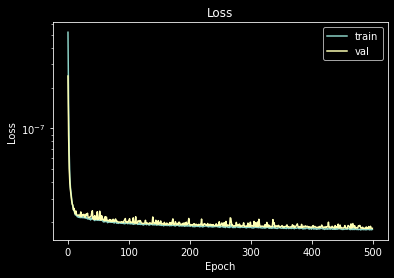

INFO:tensorflow:Assets written to: ./models/s2s_16_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 24.498573980402846
    Test Sum: 1.6532585369423032


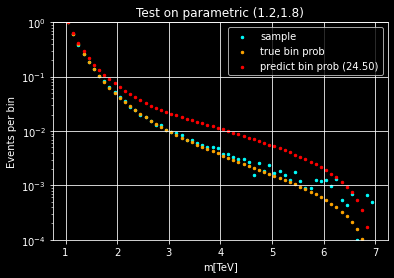

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 24.859226417802944
    Test Sum: 1.653161154827103


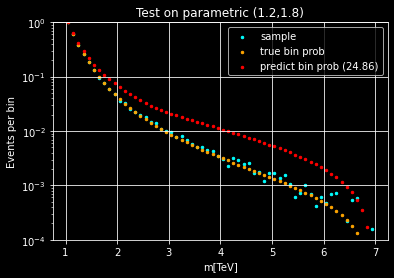

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 26.76247739918693
    Test Sum: 1.6532164392992854


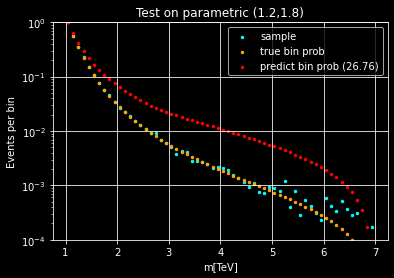

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 27.08903007800892
    Test Sum: 1.653264256194234


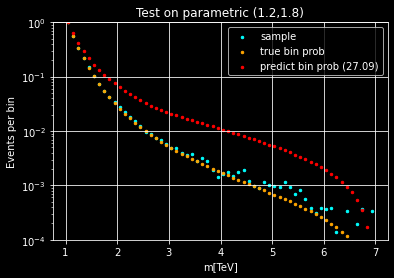

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 26.572886770074707
    Test Sum: 1.6531770990695804


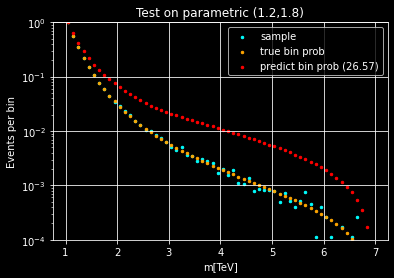

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 24.392230137313327
    Test Sum: 1.6531216509174556


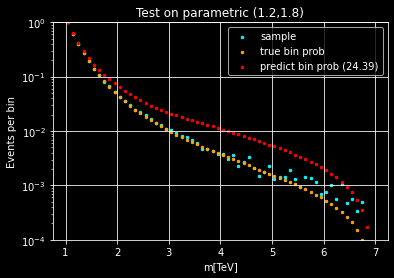

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 29.62294520245272
    Test Sum: 1.6532296563964337


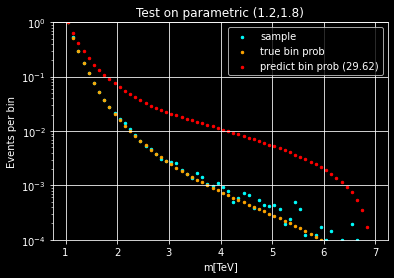

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 29.363003523987516
    Test Sum: 1.6532332000788301


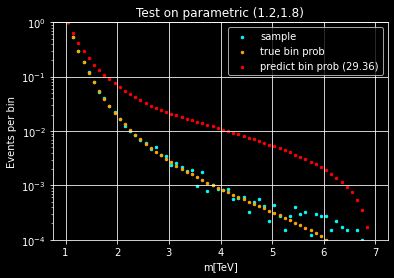

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 25.35098453969991
    Test Sum: 1.6531574588734657


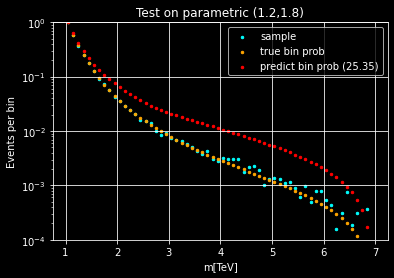

    Testing ./models/s2s_16_128_50_500_1.000000_exp...
16
    Test MSE: 30.28816648366348
    Test Sum: 1.6532535508740693


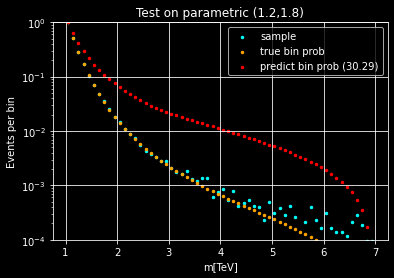

Curr model: ./models/s2s_32_128_50_500_1.000000_exp
    Training ./models/s2s_32_128_50_500_1.000000_exp...
    latent_dim=32
    batch_size=128
    patience=50
    epochs=500


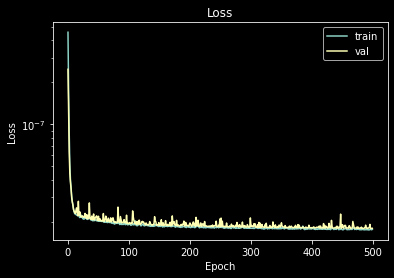

INFO:tensorflow:Assets written to: ./models/s2s_32_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 25.111968680398167
    Test Sum: 1.5318917043041438


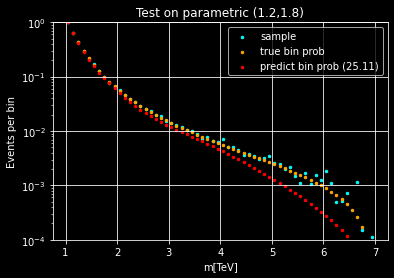

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 27.765123232899857
    Test Sum: 1.5330415351781994


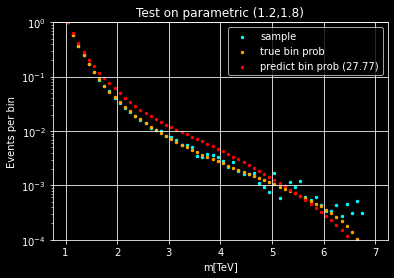

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 26.548151717103934
    Test Sum: 1.5322216989006847


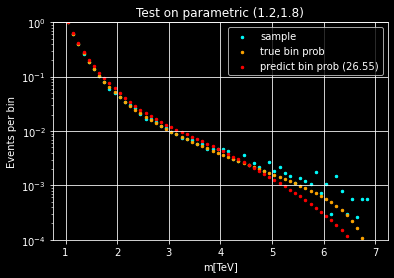

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 26.633986314306142
    Test Sum: 1.5323505927808583


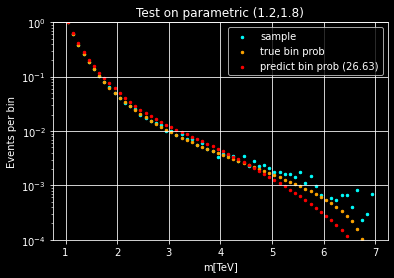

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 29.734925157025813
    Test Sum: 1.533421342028305


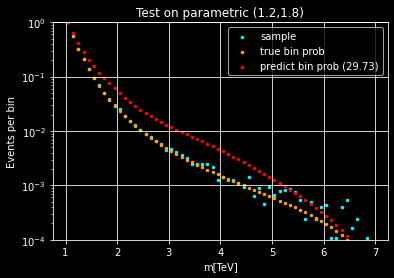

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 24.773223316659866
    Test Sum: 1.5316978869959712


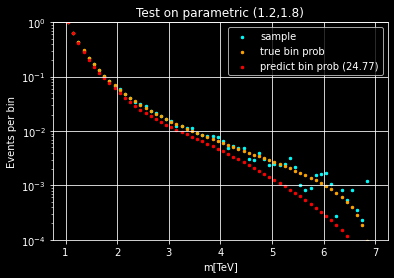

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 29.507107359456782
    Test Sum: 1.5333990317303687


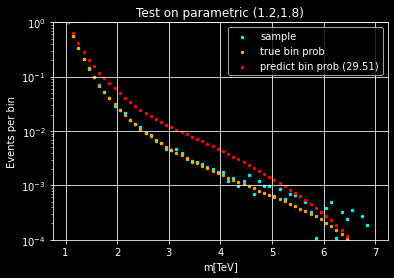

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 25.743861277663875
    Test Sum: 1.5324737515766174


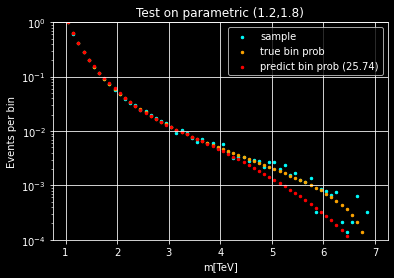

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 26.218397745339715
    Test Sum: 1.5325801835861057


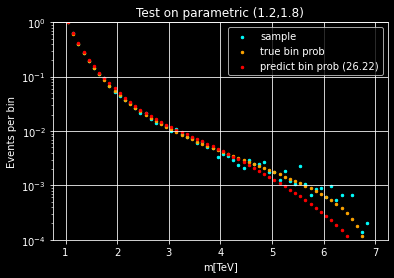

    Testing ./models/s2s_32_128_50_500_1.000000_exp...
32
    Test MSE: 25.91447181350693
    Test Sum: 1.532251003663987


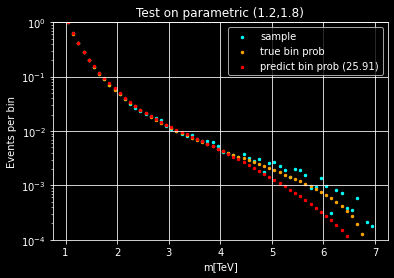

Curr model: ./models/s2s_64_128_50_500_1.000000_exp
    Training ./models/s2s_64_128_50_500_1.000000_exp...
    latent_dim=64
    batch_size=128
    patience=50
    epochs=500


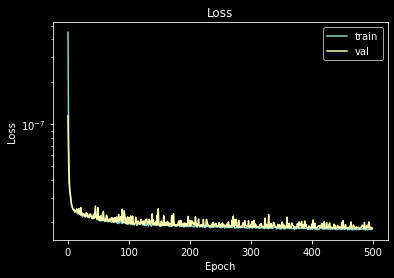

INFO:tensorflow:Assets written to: ./models/s2s_64_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 23.087389237656204
    Test Sum: 1.5138376724207774


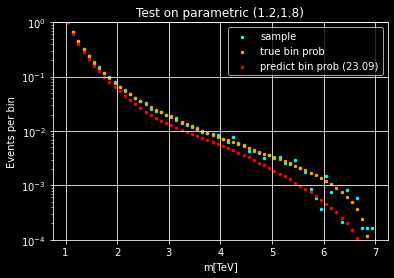

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 30.532409463140567
    Test Sum: 1.5141886812634766


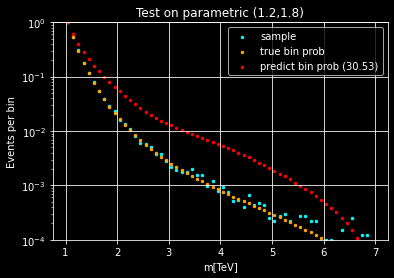

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 29.88037626817792
    Test Sum: 1.51418281160295


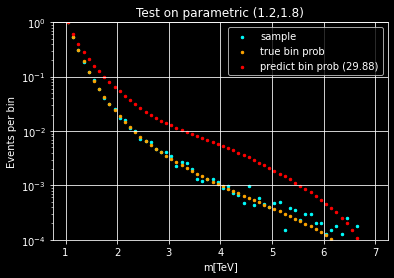

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 29.750648061736836
    Test Sum: 1.5141598107293248


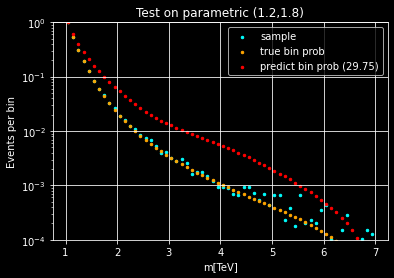

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 29.455842625966
    Test Sum: 1.5141461200546473


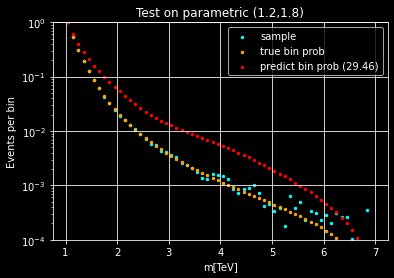

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 30.606260293533225
    Test Sum: 1.5141915798885748


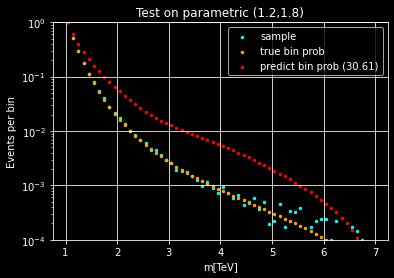

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 27.696273671840107
    Test Sum: 1.5140505576273426


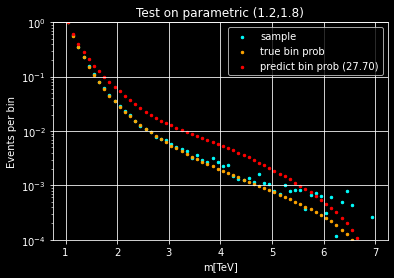

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 26.729482661631177
    Test Sum: 1.5139613694045693


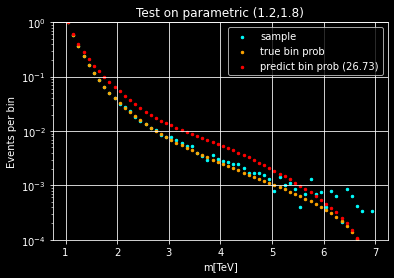

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 28.242957824923593
    Test Sum: 1.5141151138814166


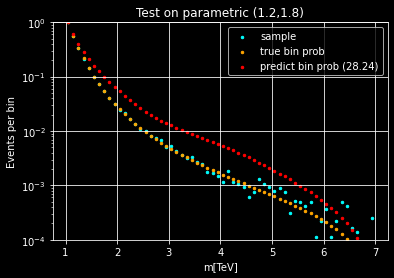

    Testing ./models/s2s_64_128_50_500_1.000000_exp...
64
    Test MSE: 22.420013555731245
    Test Sum: 1.5131695490563288


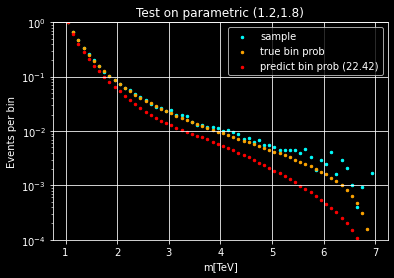

Curr model: ./models/s2s_256_128_50_500_1.000000_exp
    Training ./models/s2s_256_128_50_500_1.000000_exp...
    latent_dim=256
    batch_size=128
    patience=50
    epochs=500


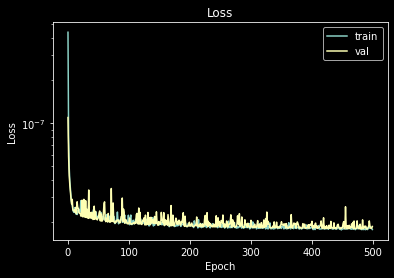

INFO:tensorflow:Assets written to: ./models/s2s_256_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 30.98080308045893
    Test Sum: 1.452198730665259


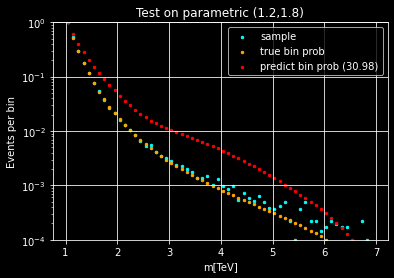

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 24.350457443951917
    Test Sum: 1.4518339119385928


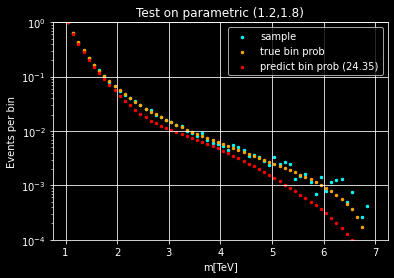

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 25.409985629995116
    Test Sum: 1.4519491932587698


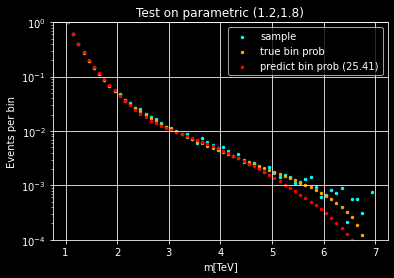

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 24.455713600208313
    Test Sum: 1.4518300504423678


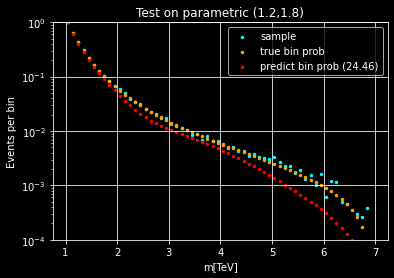

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 30.915279504351332
    Test Sum: 1.452208697446622


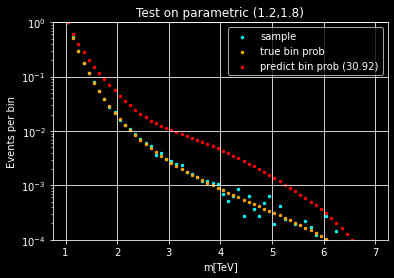

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 29.381133718659996
    Test Sum: 1.4521628983784467


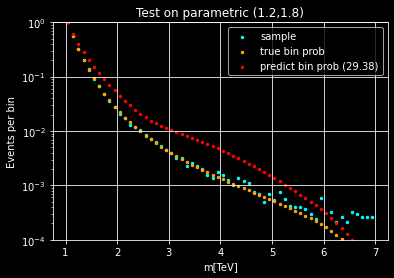

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 24.313999202176625
    Test Sum: 1.4518082332797348


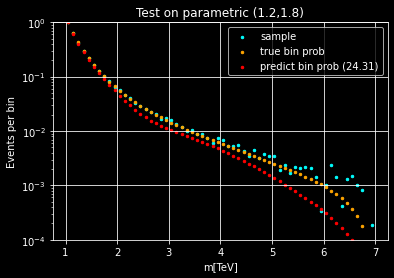

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 30.112135137396027
    Test Sum: 1.4521729986881837


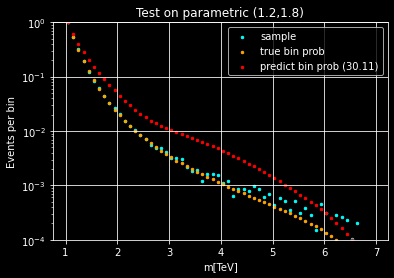

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 28.676284917725617
    Test Sum: 1.4521309970878065


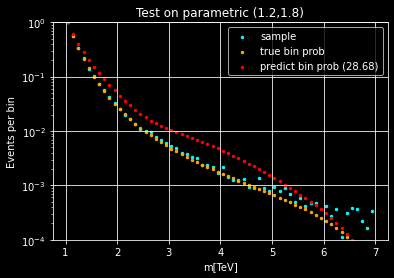

    Testing ./models/s2s_256_128_50_500_1.000000_exp...
256
    Test MSE: 31.130708280919844
    Test Sum: 1.4522055595880374


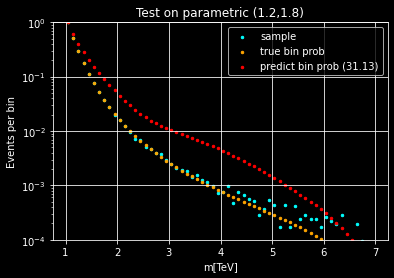

Curr model: ./models/s2s_400_128_50_500_1.000000_exp
    Training ./models/s2s_400_128_50_500_1.000000_exp...
    latent_dim=400
    batch_size=128
    patience=50
    epochs=500


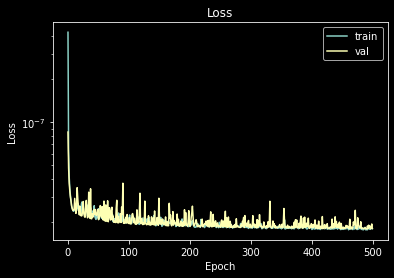

INFO:tensorflow:Assets written to: ./models/s2s_400_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 23.546028893931677
    Test Sum: 1.4311187920393422


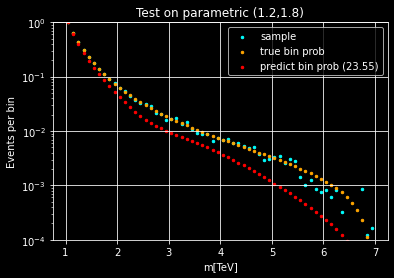

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 28.017010602375862
    Test Sum: 1.4313750065630302


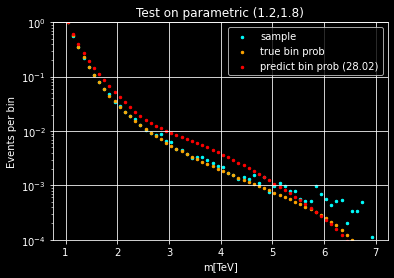

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 31.056199739691458
    Test Sum: 1.4314741240814328


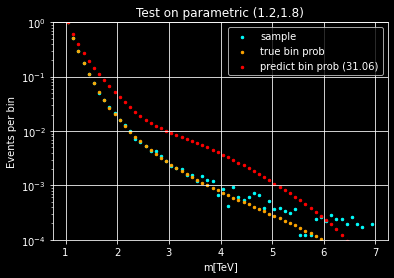

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 26.098706589100107
    Test Sum: 1.4312716121785343


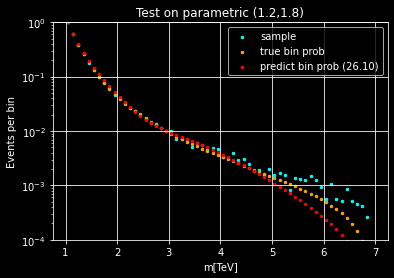

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 29.136439575722346
    Test Sum: 1.431438243133016


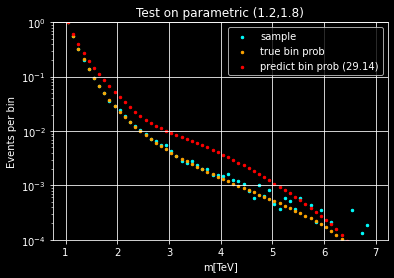

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 29.843040378165202
    Test Sum: 1.431442181696184


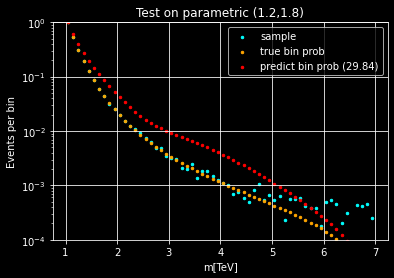

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 30.578552805251437
    Test Sum: 1.4314642220269889


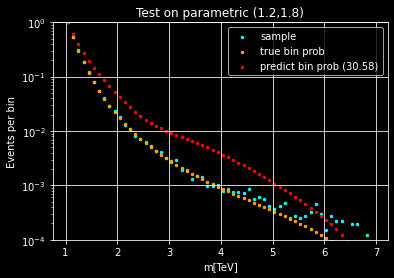

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 27.095550824231815
    Test Sum: 1.4313553234096617


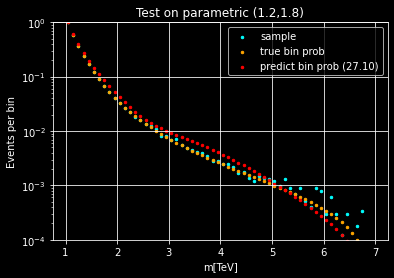

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 29.90987838250678
    Test Sum: 1.4314495524158701


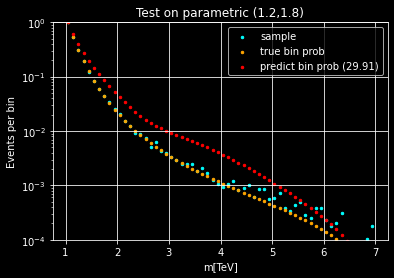

    Testing ./models/s2s_400_128_50_500_1.000000_exp...
400
    Test MSE: 26.290596233924127
    Test Sum: 1.4313139541773126


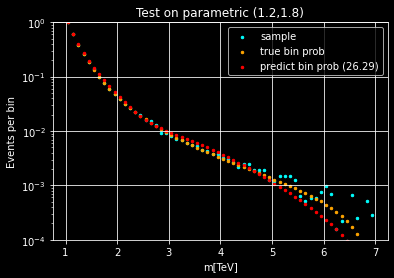

Curr model: ./models/s2s_500_128_50_500_1.000000_exp
    Training ./models/s2s_500_128_50_500_1.000000_exp...
    latent_dim=500
    batch_size=128
    patience=50
    epochs=500


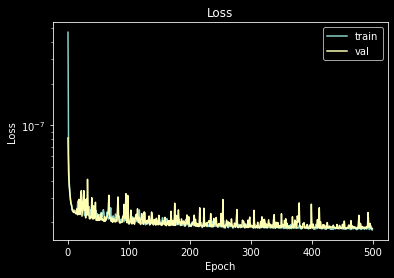

INFO:tensorflow:Assets written to: ./models/s2s_500_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 29.52532524881841
    Test Sum: 1.4391539545031264


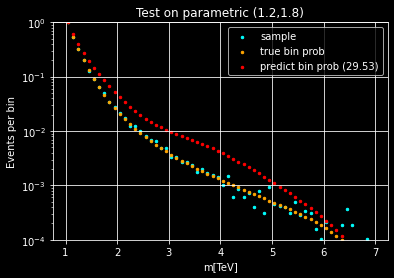

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 26.599723398180895
    Test Sum: 1.438925294787623


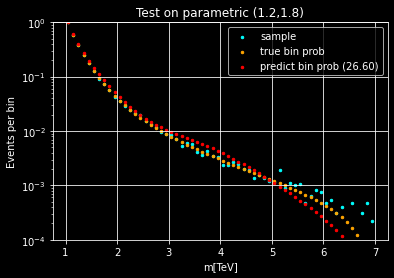

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 27.064006796174233
    Test Sum: 1.4389746136730537


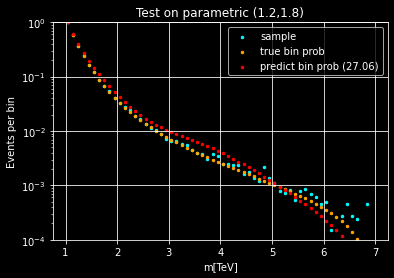

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 24.19622142548914
    Test Sum: 1.4385363488690928


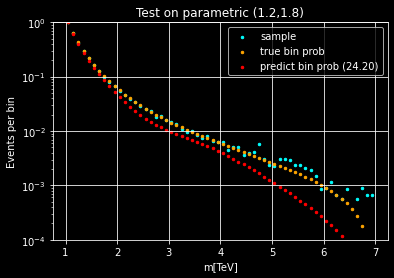

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 30.93472942933875
    Test Sum: 1.4391934641171247


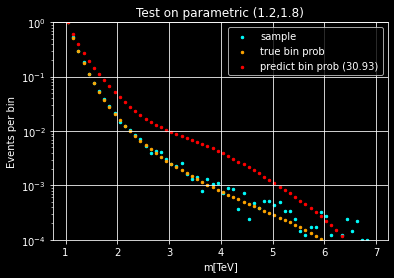

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 30.235381307604317
    Test Sum: 1.439167078002356


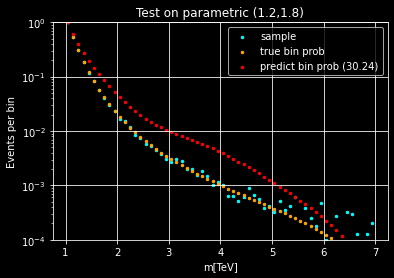

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 27.36037177932041
    Test Sum: 1.4389537806855515


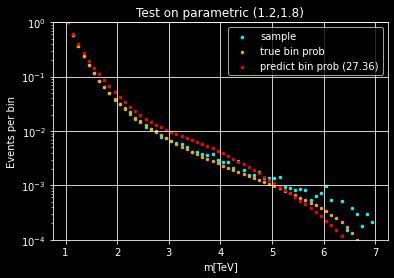

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 29.173442242156664
    Test Sum: 1.439097240450792


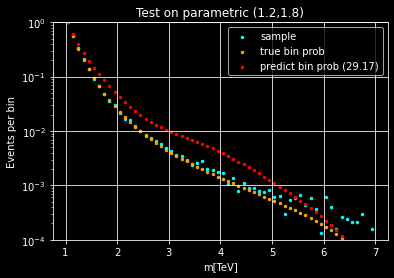

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 26.46685103112647
    Test Sum: 1.438872087863274


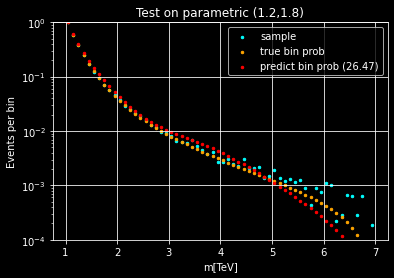

    Testing ./models/s2s_500_128_50_500_1.000000_exp...
500
    Test MSE: 25.195181201113616
    Test Sum: 1.4386999745620415


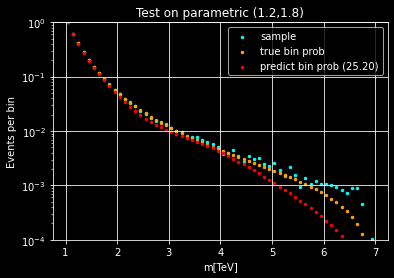

Curr model: ./models/s2s_600_128_50_500_1.000000_exp
    Training ./models/s2s_600_128_50_500_1.000000_exp...
    latent_dim=600
    batch_size=128
    patience=50
    epochs=500


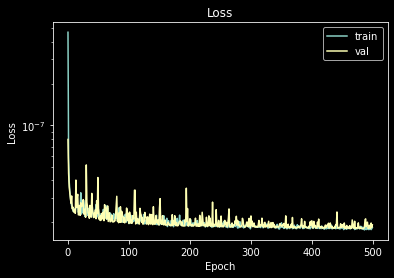

INFO:tensorflow:Assets written to: ./models/s2s_600_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 25.02366425720485
    Test Sum: 1.406570094753988


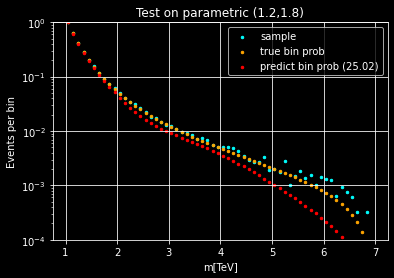

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 24.290139223886435
    Test Sum: 1.4064382447395474


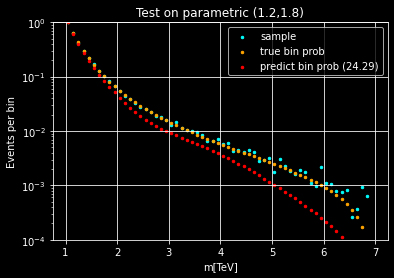

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 25.28288215580674
    Test Sum: 1.406734152988065


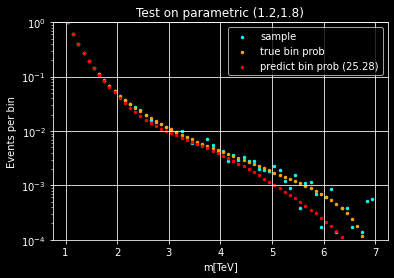

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 28.163277951228515
    Test Sum: 1.4070825937669724


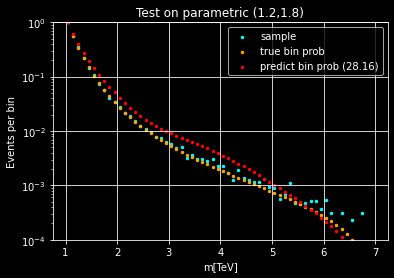

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 29.949693401066913
    Test Sum: 1.4072324038716033


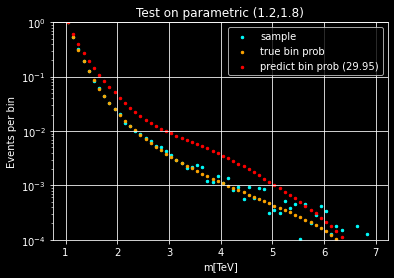

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 30.830708237336328
    Test Sum: 1.407296076999046


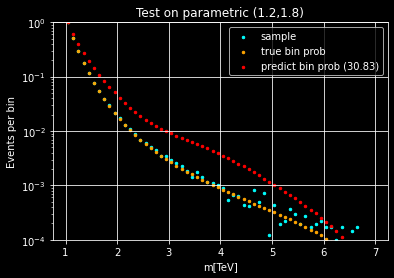

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 25.522235589500525
    Test Sum: 1.4066605055704713


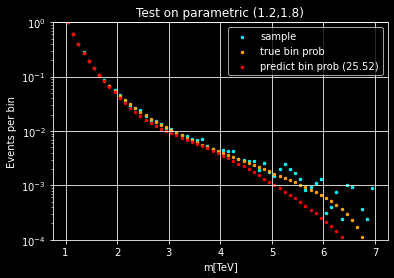

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 28.104259305674454
    Test Sum: 1.4071004588040523


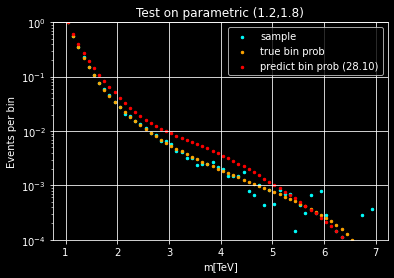

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 26.254054596337244
    Test Sum: 1.4067510527092963


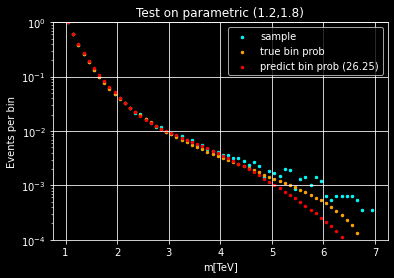

    Testing ./models/s2s_600_128_50_500_1.000000_exp...
600
    Test MSE: 24.800397289653954
    Test Sum: 1.406518757226877


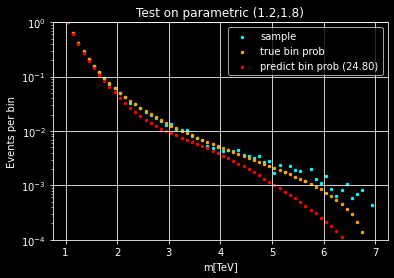

Curr model: ./models/s2s_700_128_50_500_1.000000_exp
    Training ./models/s2s_700_128_50_500_1.000000_exp...
    latent_dim=700
    batch_size=128
    patience=50
    epochs=500


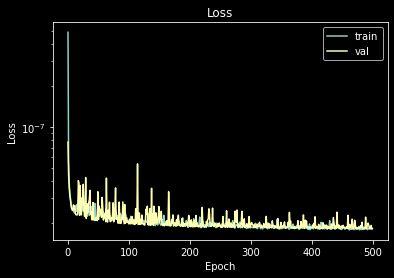

INFO:tensorflow:Assets written to: ./models/s2s_700_128_50_500_1.000000_exp/assets
    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 28.62904157005832
    Test Sum: 1.4298158126184717


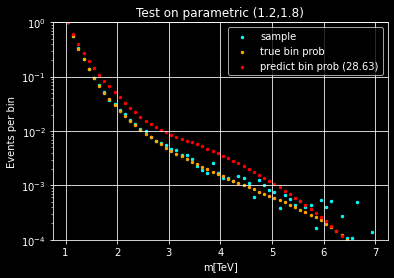

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 27.25446087071089
    Test Sum: 1.4297764425864443


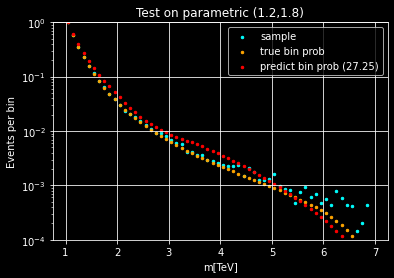

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 24.996134258735744
    Test Sum: 1.4297118737595156


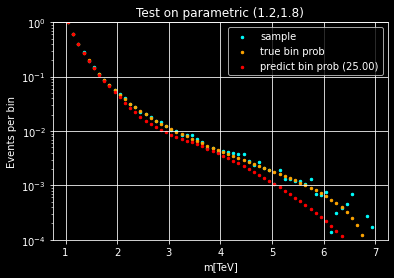

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 25.042910831097608
    Test Sum: 1.429697212879546


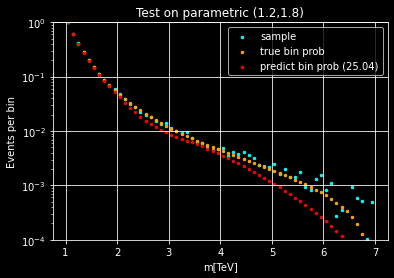

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 30.975484219863652
    Test Sum: 1.4298570124665275


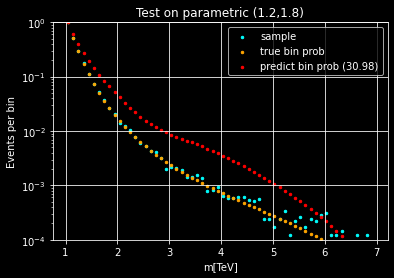

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 28.873738717448646
    Test Sum: 1.4298229832202196


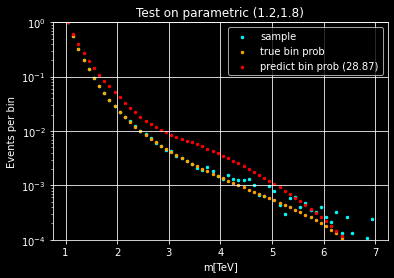

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 27.645836544545233
    Test Sum: 1.4297944569261745


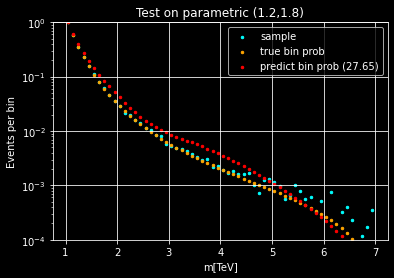

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 27.235156588707106
    Test Sum: 1.4297864264808595


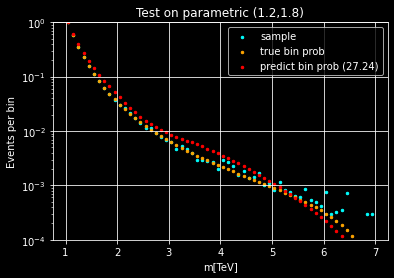

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 31.83727580225594
    Test Sum: 1.4298672322183847


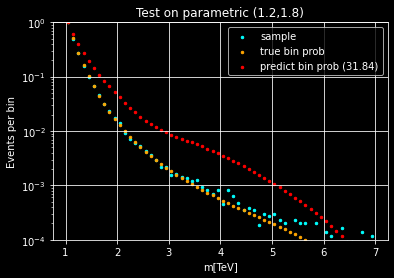

    Testing ./models/s2s_700_128_50_500_1.000000_exp...
700
    Test MSE: 31.55749193448991
    Test Sum: 1.4298617533640936


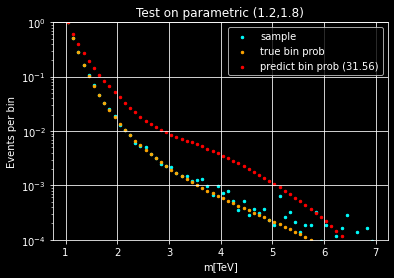

In [70]:
for ld in (16,32,64,256,400,500,600,700):
    train_test(sample_weight, X, Y, latent_dim=ld, batch_size=128, patience=50, epochs=500, test_num=10, verbose=0)

In [68]:
#for bs in (16,32,64,128,256,400,500,600,700,800):
#    train_test(sample_weight, X, Y, latent_dim=32, batch_size=bs, patience=400, epochs=500, test_num=10, verbose=0)

## Visualize attention

## Visualize train data pattern

In [95]:
def probs2events(X):
    X = X.reshape(NP, NBINS)
    res = np.zeros((NP, NBINS))
    for i in range(X.shape[0]):
        x = X[i]
        x.reshape(NBINS)
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        x = (x * NE) 
        x = scaler.fit_transform(x.reshape(-1,1))
        x = x.reshape(NBINS)
        res[i] = x
    return res

In [96]:
peY = probs2events(Y)

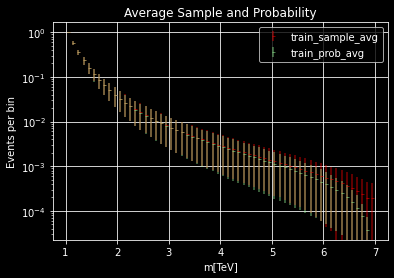

In [20]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])

X_avg = np.average(pX, axis=0)
X_var = np.std(pX, axis=0)

Y_avg = np.average(peY, axis=0)
Y_var = np.std(peY, axis=0)

plt.yscale("log")
plt.errorbar(binsc, X_avg, yerr=X_var, fmt='_',markersize=3, label="train_sample_avg", alpha=0.5, color="red")
plt.errorbar(binsc, Y_avg, yerr=Y_var, fmt='_',markersize=3, label="train_prob_avg", alpha=0.5, color="palegreen")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.title("Average Sample and Probability")
plt.legend()
plt.show()

1.2845360366627574


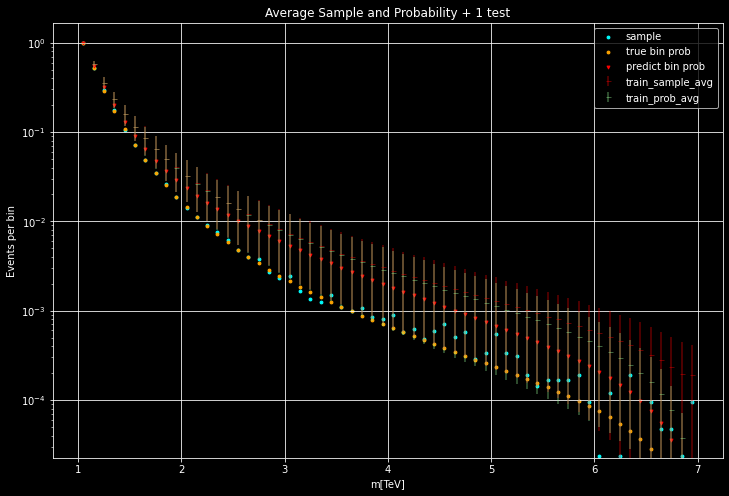

1.309100305661559


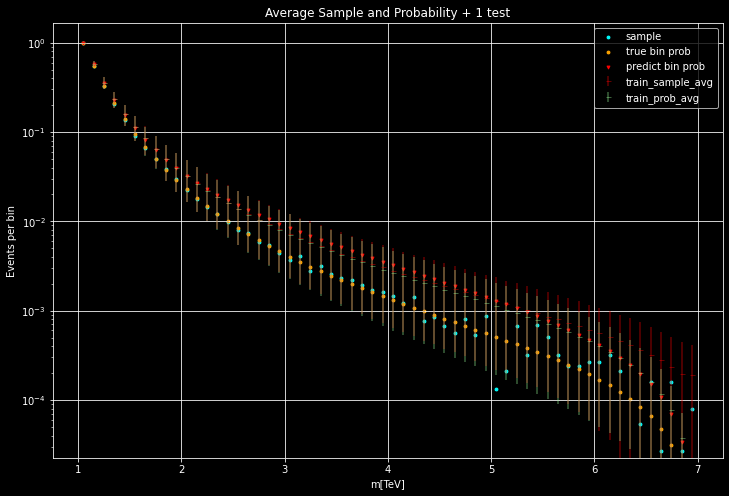

1.3015877986326814


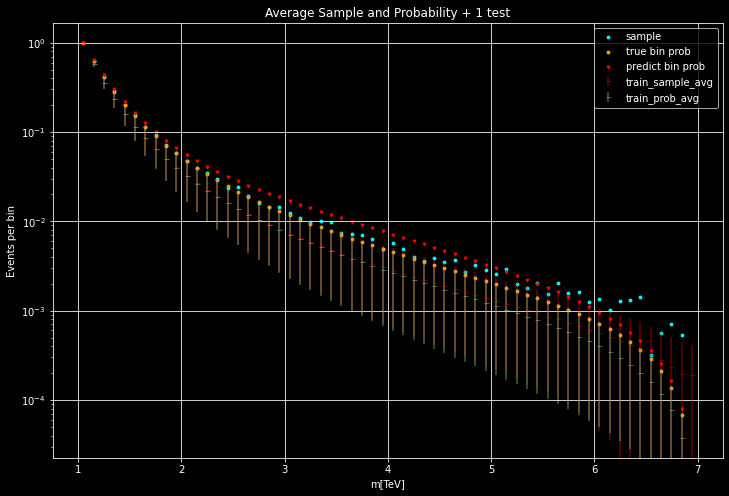

1.3067183527164161


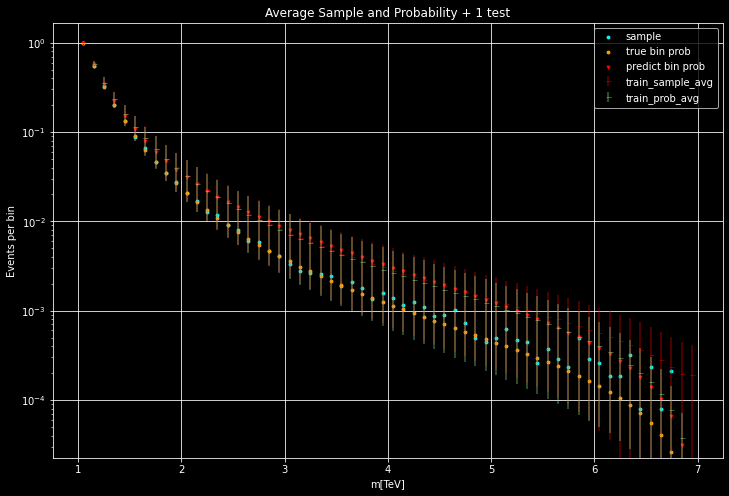

1.3101101201027632


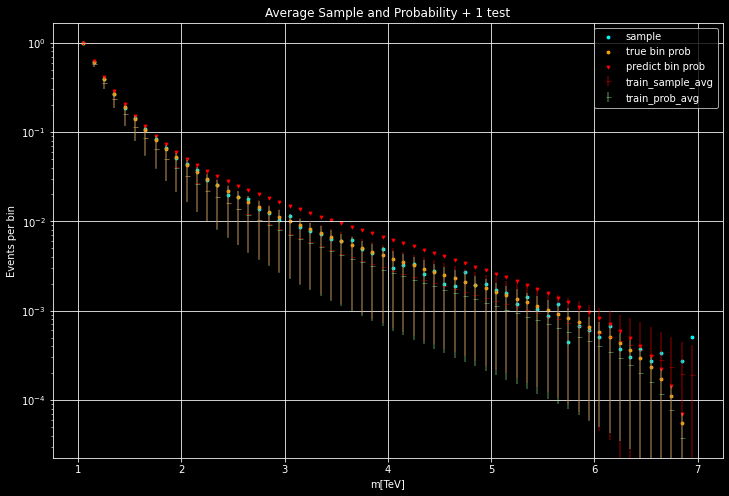

In [87]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])

X_avg = np.average(pX, axis=0)
X_var = np.std(pX, axis=0)

Y_avg = np.average(peY, axis=0)
Y_var = np.std(peY, axis=0)


for i in range(5):
    X_test, Y_test, Y_hat = test1(1.2, 1.8, plot=False)
    plt.figure(figsize=(12,8))
    plt.yscale("log")
    plt.errorbar(binsc, X_avg, yerr=X_var, fmt='_',markersize=5, label="train_sample_avg",alpha=0.4,color="red")
    plt.errorbar(binsc, Y_avg, yerr=Y_var, fmt='_',markersize=5, label="train_prob_avg",alpha=0.4, color="palegreen")
    plt.scatter(binsc,X_test, s=8, label="sample", color="cyan")
    plt.scatter(binsc, prob2event(Y_test), s=8, label="true bin prob", c="orange")
    plt.scatter(binsc, prob2event(Y_hat), s=8, label="predict bin prob", marker='v',c="red")
    plt.grid()
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.title("Average Sample and Probability + 1 test")
    plt.legend()
    plt.show()

## Compare with simple Dense Network

In [88]:
def create_model(inx):
    # Create the model 
    #initializer = tf.keras.initializers.Identity()
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = inx, activation = 'linear', input_shape=[inx]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = inx, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")

    # Display the model
    model.summary()

    return model

In [89]:
model_dnn = create_model(60)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                3904      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 60)                3900      
Total params: 44,552
Trainable params: 44,552
Non-trainable params: 0
__________________________________________________

In [90]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=15, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [91]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])
model_dnn.fit(pX, pY, epochs=100, verbose=1, batch_size=16, callbacks=callbacks, validation_split=0.4)

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 1.1365e-04 - val_loss: 6.8279e-07
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 3.8439e-07 - val_loss: 2.8837e-07
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 3.4887e-07 - val_loss: 3.9142e-07
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 3.5233e-07 - val_loss: 2.9994e-07
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 3.5342e-07 - val_loss: 3.2952e-07
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 3.4779e-07 - val_loss: 2.2040e-07
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 3.4924e-07 - val_loss: 4.2887e-07
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 3.6149e-07 - val_loss: 4.0789e-07
Epoch 9/100
375/375 [==============================] - 1s 2ms/step - loss: 2.8748e-07 - val_loss: 5.5340e-07
Epoch 10/100
375/37

In [92]:
def test1vsDNN(lowp, highp, ne=NE, plot=True):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    X_test = X_test.reshape(1, NBINS)
    Y_hat_dnn = model_dnn.predict(X_test)
    
    X_test = X_test.reshape(1, NBINS, 1)
    Y_hat = decode_sequence(X_test)
    #print(Y_hat_dnn)
    print(sum(Y_hat), np.sum(Y_hat_dnn), np.sum(X_test), np.sum(X_test.reshape(1,60)))

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample", c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="LSTM predict bin prob", marker='v',c="red")
        plt.scatter(binsc, prob2event(Y_hat_dnn), s=6, marker='^', label="DNN predict bin prob", c="violet")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("LSTM vs DNN Test on parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

1.2978817615658045 1.0016232 3.496657606699478 3.496657606699478


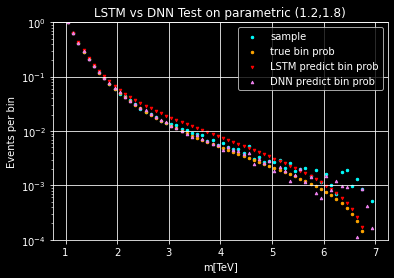

1.2958958055824041 1.0020546 2.4769433465085644 2.4769433465085644


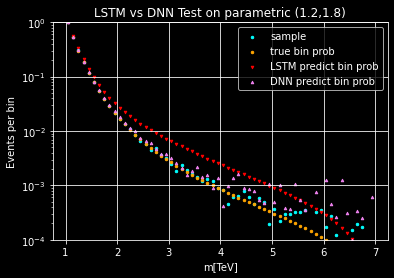

1.2679709722287953 1.0012761 3.9484510116698845 3.9484510116698845


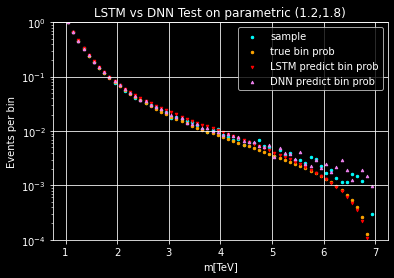

1.3108068006113172 1.0024594 2.6805349182763742 2.6805349182763742


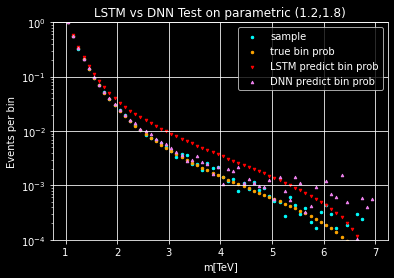

1.3042812063358724 1.0016503 3.3837070359176216 3.3837070359176216


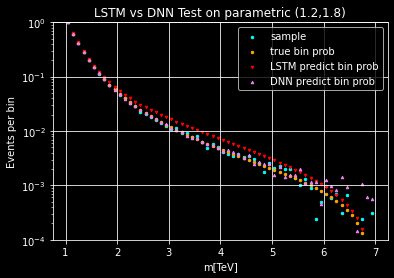

1.2760436688549817 1.0019695 2.3208095847388623 2.3208095847388623


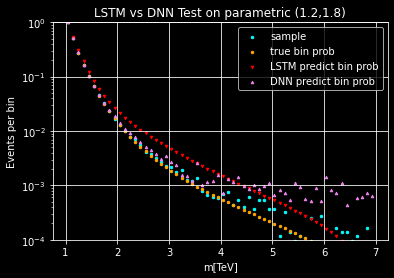

1.2672495087608695 1.002121 2.2673480976717775 2.2673480976717775


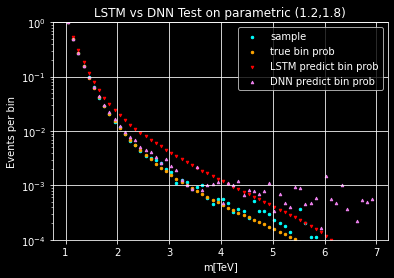

1.2812453717924654 1.001693 2.3560234138972804 2.3560234138972804


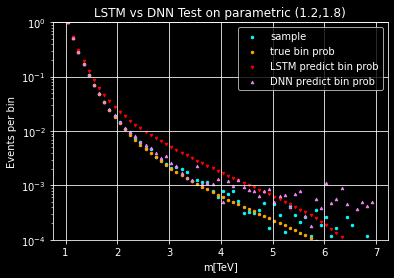

1.276426323223859 1.0006163 3.83206862421643 3.83206862421643


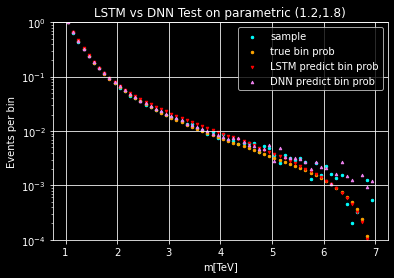

1.292293471749872 1.0017679 2.4441608168474787 2.4441608168474787


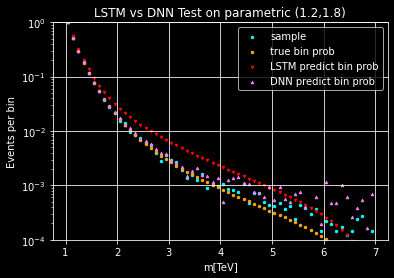

In [93]:
for i in range(10):
    _ = test1vsDNN(1.2, 1.8)